In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Sift algorithm aims at finding the best **descriptor** points of an image. Usually they are corner of edges, points that are uniquely present in the image.

# Sift application to stich 2 images to create panorama

In [2]:
class Stitcher:
    def __init__(self):
        pass

    def stitch(self, images, ratio=0.75, reprojThresh=4.0,
        showMatches=False):
        # detect keypoints using sift
        (imageL, imageR) = images
        (kpsL, featuresL) = self.detectAndDescribe(imageL)
        (kpsR, featuresR) = self.detectAndDescribe(imageR)

        # match features between the two images
        M = self.matchKeypoints(kpsR, kpsL,
            featuresR, featuresL, ratio, reprojThresh)

        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None

        # otherwise, apply a perspective warp to stitch the images together
        # we warp the right image with the homography
        (matches, H, status) = M
        result = cv2.warpPerspective(imageR, H,
            (imageR.shape[1] + imageL.shape[1], imageR.shape[0]))
        # Fill the left side of the image with the left image
        minH, minW = min(imageL.shape[0], imageR.shape[0]), min(imageL.shape[1], imageR.shape[1])
        result[0:minH, 0:minW] = imageL[0:minH, 0:minW]

        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageR, imageL, kpsR, kpsL, matches,
                status)

            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)

        # return the stitched image
        return result

    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect and extract features from the image
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
        ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                reprojThresh)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None
    
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully
            # matched
            if s == 1:
                # draw the match
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # return the visualization
        return vis

[ WARN:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-tetsazc6/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


[]

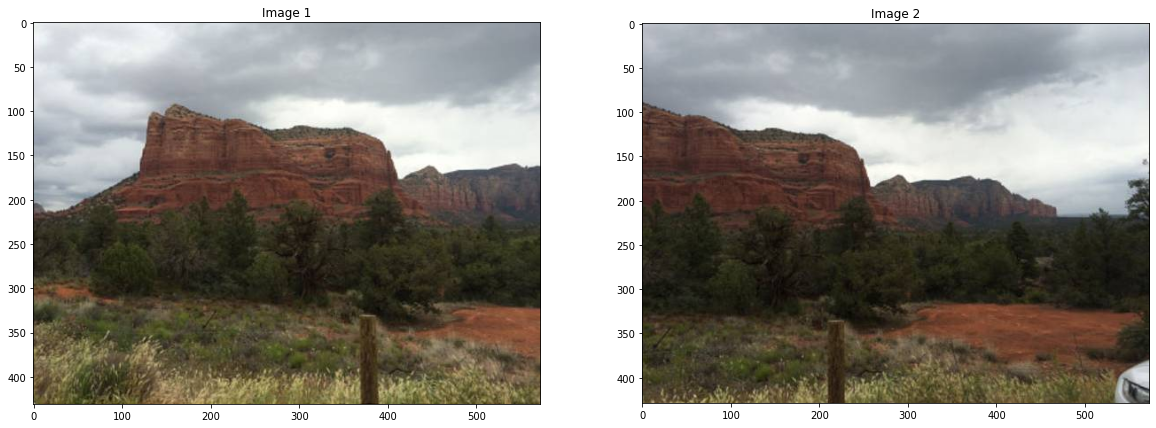

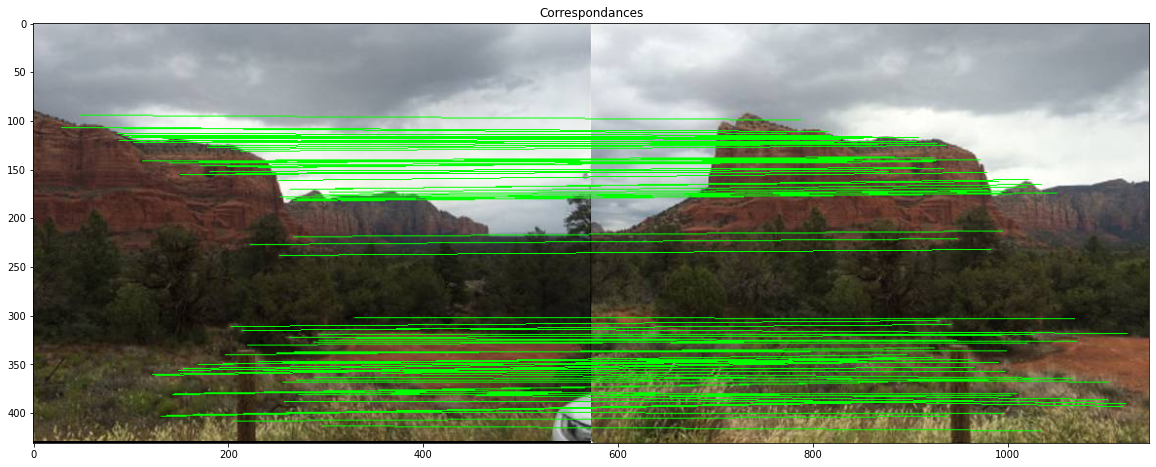

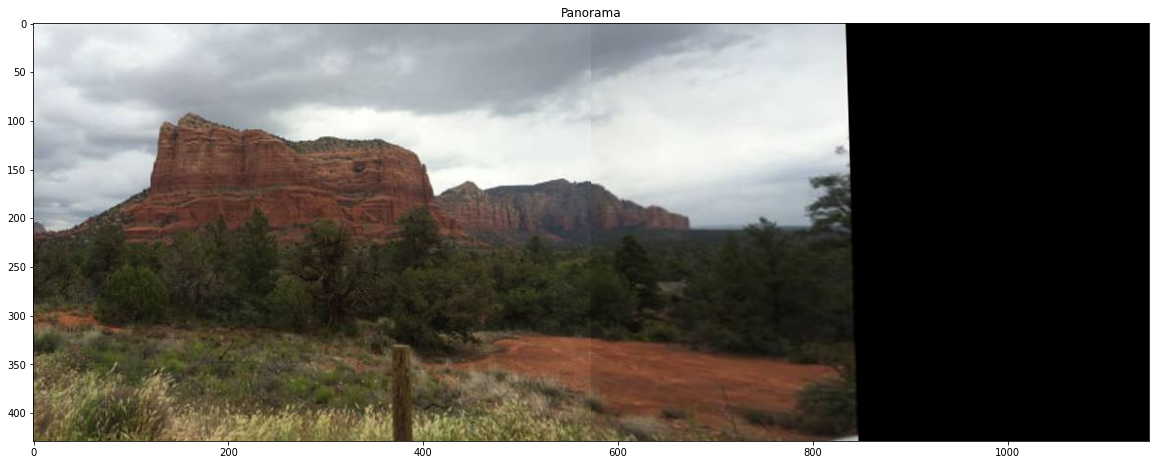

In [3]:
# load the two images. Remember to resize them for faster processing if they are too large
imageA = cv2.imread("images/panorama_1.jpg")
imageB = cv2.imread("images/panorama_2.jpg")

# stitch the images together to create a panorama
stitcher = Stitcher()
result, vis = stitcher.stitch([imageA, imageB], showMatches=True)

# show the images
fig, ax = plt.subplots(1,2, figsize=(20,10))
imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)
vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
ax[0].imshow(imageA)
ax[0].set_title("Image 1")
ax[1].imshow(imageB)
ax[1].set_title("Image 2")
plt.plot()

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.imshow(vis)
ax.set_title("Correspondances")
plt.plot()


fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.imshow(result)
ax.set_title("Panorama")
plt.plot()

TODO : ne pas avoir bande noire, remplir reste noir par padding réplique miroir sur droite photo

# Track skier through video with SIFT

## Read video

In [29]:
vidcap = cv2.VideoCapture('videos/ski.avi')
success,image = vidcap.read()
count = 0
images = []
while success:
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #cv2.imwrite("frame%d.jpg" % count, image)  
    success,image = vidcap.read()
    count += 1

In [30]:
num_images = len(images)
print('Size video frames', images[0].shape)
print('number of frames', num_images)

Size video frames (480, 1280, 3)
number of frames 120


## Find SIFT matches between two frames

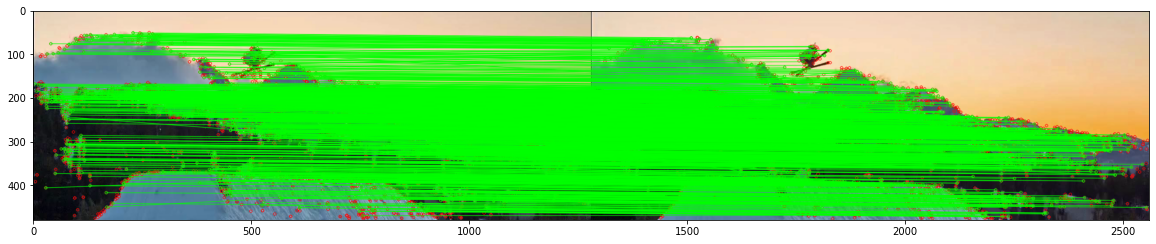

In [31]:
img1 = images[30]
img2 = images[31]

def match(img1, img2):
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    num_matches = 0
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            num_matches += 1
    
    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = cv2.DrawMatchesFlags_DEFAULT)
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
    ax.imshow(img3)
    plt.plot()

match(img1, img2)
    


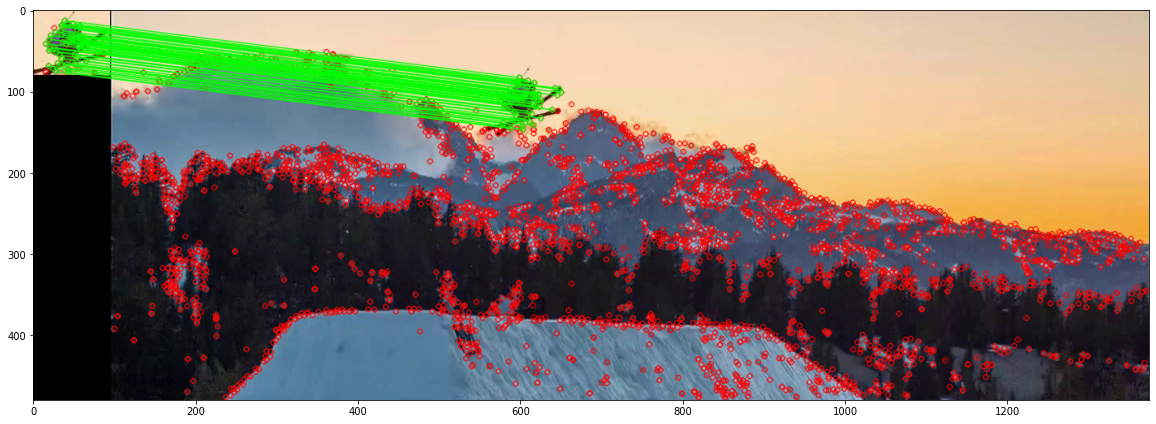

In [32]:
img1 = images[30][70:70+80, 465:465+95]
img2 = images[30]
match(img1,img2)

## Find skieur in frame

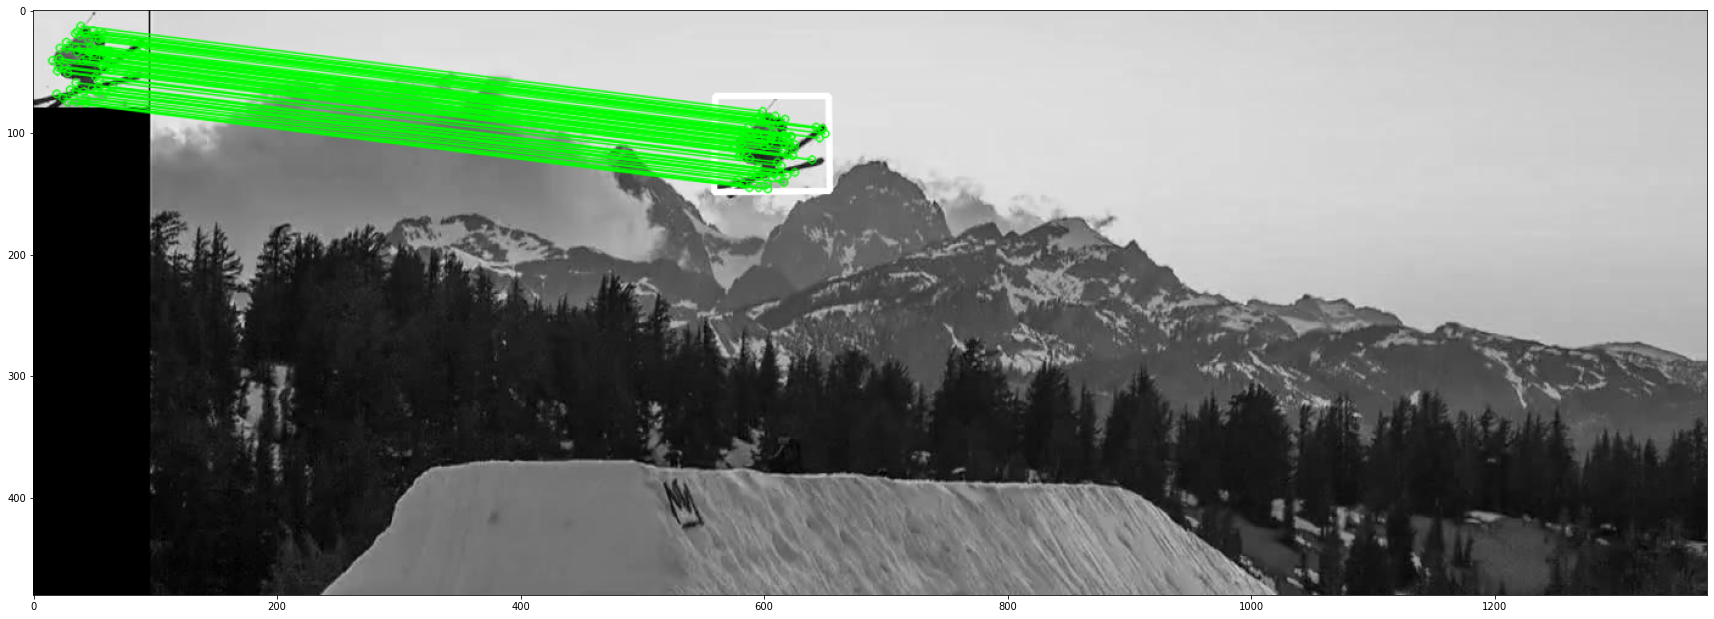

In [34]:
import numpy as np
MIN_MATCH_COUNT=5
sift = cv2.xfeatures2d.SIFT_create()

def find_homography(img1,img2):
    f, ax = plt.subplots(1,1, figsize=(30,15))
    
    # Initiate SIFT detector
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
    
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

    ax.imshow(img3, 'gray'),plt.show()

find_homography(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY),cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY))

## Follow skieur throughout video

### 1. By finding region with skieur and find new SIFTs in it

Found 64 points.
Found 18 points.
Found 8 points.
Found 6 points.
Not enough matches are found - 6/8


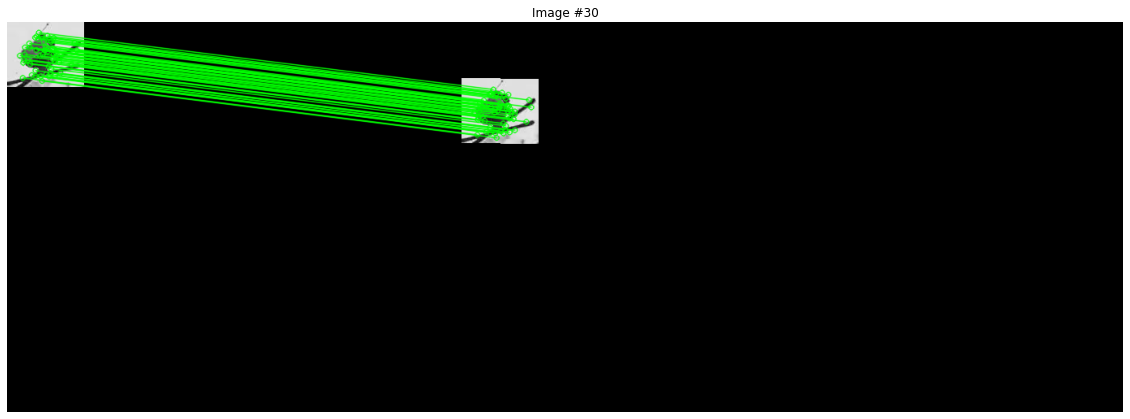

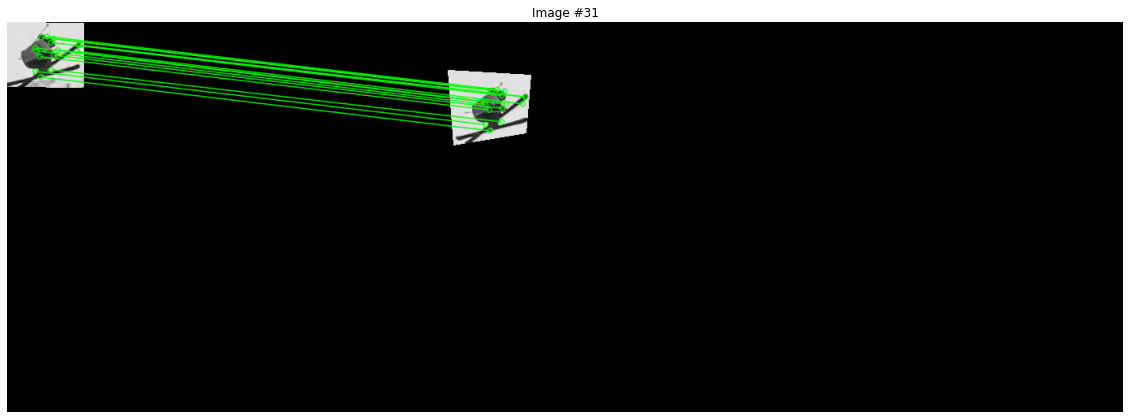

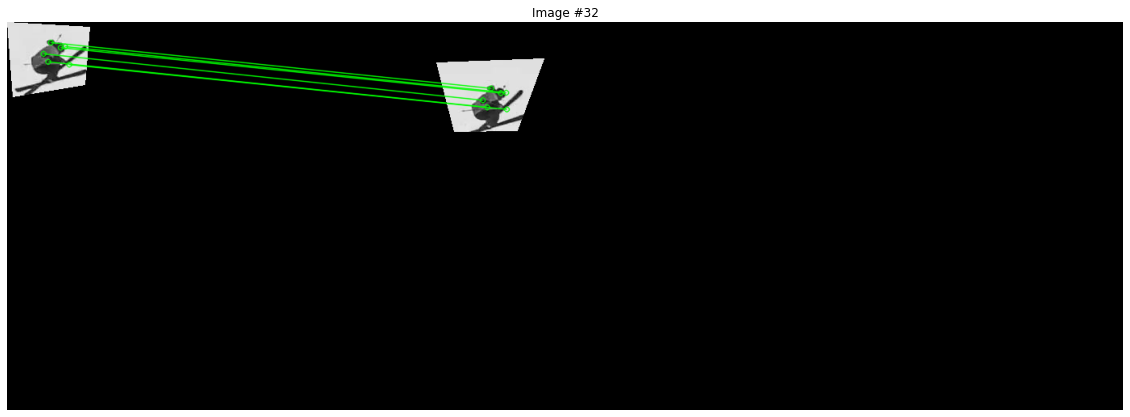

In [36]:
MIN_MATCH_COUNT=8


def find_match(img1, img2, i):
    # Initiate SIFT detector
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    print(f"Found {len(good)} points.")
    
    if len(good)>=MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.LMEDS,3)
        matchesMask = mask.ravel().tolist()
        #print(np.sum(matchesMask))
        
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        # draw square
        #ax.imshow(cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA), cmap="gray")
        
        # creating new img1
        roi_corners = [np.int32(dst)]
        mask = np.zeros(img2.shape, dtype=np.uint8)
        cv2.fillPoly(mask, roi_corners, 255)
        img2 = cv2.bitwise_and(img2, mask)

        rect = cv2.boundingRect(np.int32(dst))
        x,y,w,h = rect
        
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

        img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
        
        fig, ax = plt.subplots(1,1, figsize=(20,10))
        ax.imshow(img3, cmap="gray")
        ax.set_title(f"Image #{i}")
        ax.axis("off")
    
        if y<0 or x<0 or h<0 or w<0:
            print("Mask problem !")
            print(roi_corners)
            return 
    
        croped = img2[y:y+h, x:x+w].copy()
        return croped
    

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        return 
    
    
def find_all_matches():
    img1 = cv2.cvtColor(images[30][70:70+80, 465:465+95], cv2.COLOR_RGB2GRAY)
    
    for i in range(30,40):
        img2 = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
        img1 = find_match(img1, img2, i)
        if img1 is None:
            break
    
find_all_matches()

Problem: The mountain points are better descriptors than the skier...

### 2. By re-using matching points in skieur found in frame as bases for finding matches in next frame

Found 65 points.
Found 23 points.


/Users/Sarah/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/Sarah/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Found 10 points.
Found 7 points.
Not enough matches are found - 7/8


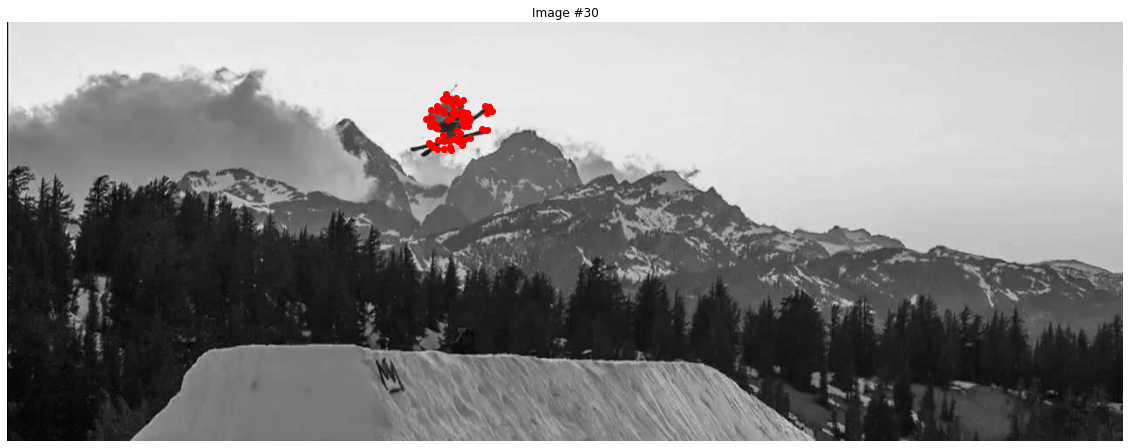

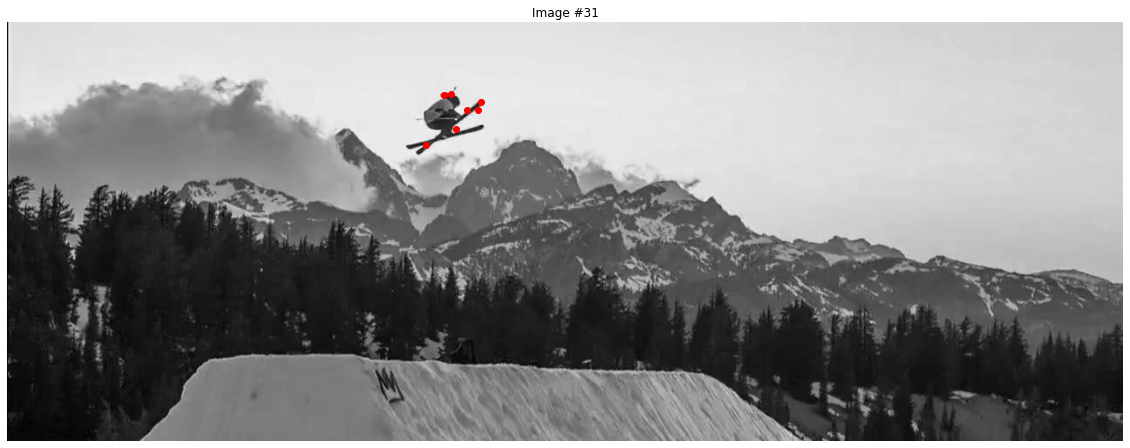

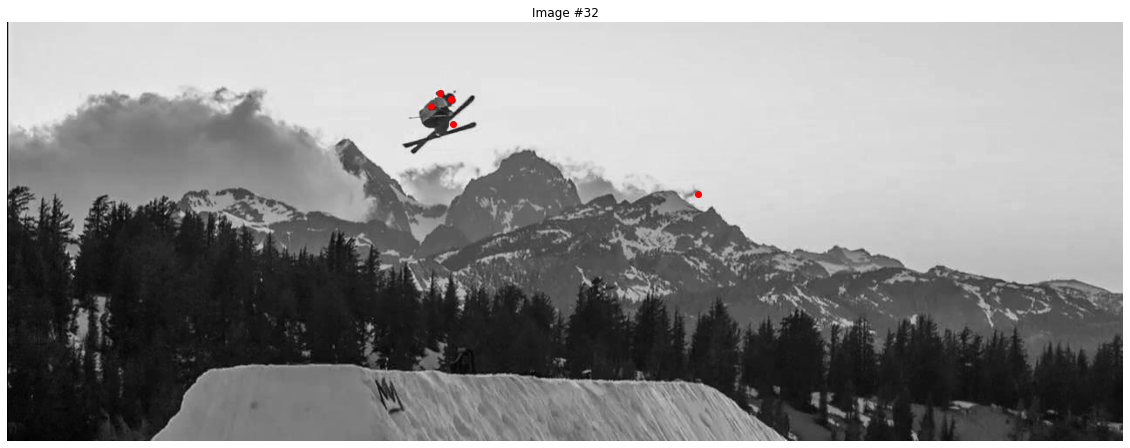

In [37]:
MIN_MATCH_COUNT=8


def find_match(kp1, des1, img2, i):
    # Initiate SIFT detector
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)
    print(f"Found {len(good)} points.")
    
    if len(good)>=MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,3)
        matchesMask = np.array(mask.ravel()).astype(np.bool)
        
        dst_pts = dst_pts.reshape(-1,2).astype(int)
        dst_pts = dst_pts[matchesMask,:]
        
        fig, ax = plt.subplots(1,1, figsize=(20,10))
        plt.scatter(dst_pts[:, 0], dst_pts[:, 1], c='r')
        ax.imshow(img2, cmap="gray")
        ax.set_title(f"Image #{i}")
        ax.axis("off")
        goodMask = np.zeros(len(des2))
        for m in good:
            goodMask[m.trainIdx] = 1
        return [ kp2[m.trainIdx] for m in good ], des2[goodMask.astype(np.bool),:]

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        return [], []
    
    
def find_all_matches():
    img1 = cv2.cvtColor(images[30][70:70+80, 465:465+95], cv2.COLOR_RGB2GRAY)
    kp1, des1 = sift.detectAndCompute(img1,None)
    #print(kp1, des1)
    
    for i in range(30,40):
        img2 = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
        kp1, des1 = find_match(kp1, des1, img2, i)
        if len(kp1)==0:
            break
    
find_all_matches()

**Problem** : since we re-use previous SIFT points, the number of matching points can only decrease, and at the end we do not have enough points...